In [12]:
#Import libraries:
import pyvista as pv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from PIL import Image, ImageDraw

## PROBLEM 1

### Part A 

We will let X3 = 4. Thus, the linear system becomes a 3x3 system and can be solved. The linear system to solves becomes: 

* $ 2x1 = 4 $
* $ 6x2 - 2x3 = 0 $
* $ 2x2 -x3 = 8 $

### Part B

In [2]:
#Defining the matrix A:
A = np.array([[2., 0., 0. ], [6., 0.,-2.],[0., 2.,-1.]])
 
# Defining b: 
b = np.array([4., 0.,8.])

In [3]:
#We can use numpy.linalog.solve to find the answer:
print("Solution using numpy:", np.linalg.solve(A, b))

Solution using numpy: [2. 7. 6.]


### Part C

One of the feasible solutions is:
2 C2H6 + 7 O2 = 4 CO2 + 6 H2O

## PROBLEM 4

### Part A

In [4]:
def read_density(units_path,file_path):
    '''
    This functions reads density
    -------------------------------------------------------------------------
    PARAMETERS: 
    -units_path,file_path
    -------------------------------------------------------------------------
    OUTPUT:
    -Returns the rho normalisation data
    -------------------------------------------------------------------------
    '''
    #Reading the units file
    units = pd.read_csv(units_path)
    
    #With .loc() we select the normalisation values for velocity,density and lenght.
    rho_0 = np.array(units.loc[units["variable"] == "rho_0"]["normalisation"])
    l_0 = np.array(units.loc[units["variable"] == "L_0"]["normalisation"])
    
    # Opening the mesh
    mesh = pv.read(file_path)
    
    # Getting the data arrays
    rho = pv.get_array(mesh, "rho", preference = 'cell') #density in code units
    
    # Convert the arrays to 2D
    rho_2D = rho.reshape(mesh.dimensions[0] - 1, mesh.dimensions[1] - 1)
    
    # Convert arrays to CGS units
    rho_cgs2D = rho_2D*rho_0
    
    return rho_cgs2D,l_0

### Part B

In [5]:
units_path = "/home/jdiego/Documents/Computacional_1/TURB_DRIVE_SUP_hr/TURB_DRIVE_SUP_hr/units.out"
file_path = "/home/jdiego/Documents/Computacional_1/TURB_DRIVE_SUP_hr/TURB_DRIVE_SUP_hr/data.0040.vtk"

#calling the function: 
rho,l_0 = read_density(units_path,file_path)

In [6]:
def plot_array(title,x_2d,y_2d,array_cgs2D,map_color):
    '''
    This functions plots the given 2D normalized array
    -------------------------------------------------------------------------
    PARAMETERS: 
    -title: tittle of the map, 
    -array_cgs2D: the array to plot  
    -map_color: perceptually-uniform colour schemes
    -------------------------------------------------------------------------
    OUTPUT:
    -Returns plot of the given array
    -------------------------------------------------------------------------
    '''
    #Plotting the given array:
    plt.figure(figsize = (5,3))
    Z = plt.pcolor(x_2d, y_2d, array_cgs2D,cmap = map_color)
    plt.title(title)
    plt.colorbar(Z)
    plt.show()

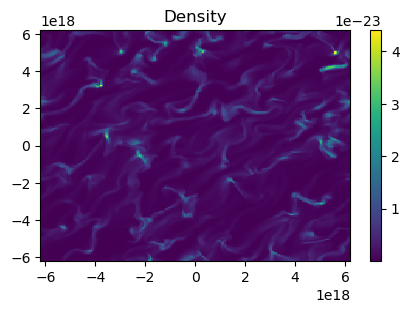

In [7]:
#Creating the mesh: 
mesh  =  pv.read(file_path)

#Create coordinate vectors:
x = np.linspace(mesh.bounds[0], mesh.bounds[1],mesh.dimensions[1] - 1)*l_0
y = np.linspace(mesh.bounds[2], mesh.bounds[3],mesh.dimensions[0] - 1)*l_0
    
#Creating the Grid
x_2d, y_2d = np.meshgrid(x, y)

#ploting density:
plot_array("Density",x_2d,y_2d,rho,'viridis')

### Part C

In [18]:
def fourier_transform(title,rho,shifted_fourier,map_color):
    '''
    This functions tranform the given array into fourier space
    -------------------------------------------------------------------------
    PARAMETERS: 
    -ttitle,rho,shifted_fourier,map_color
    -------------------------------------------------------------------------
    OUTPUT:
    -Returns fourirer transfor plot of the array and plot of the given array
    -------------------------------------------------------------------------
    '''
    
    #Ploting:
    fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10,3))
    fig.suptitle(title)
    im1 = ax1.pcolor(np.log10(np.abs(shifted_fourier)), shading='auto', cmap =map_color)
    fig.colorbar(im1)
    im2 = ax2.pcolor(x_2d, y_2d,rho,cmap = map_color)
    fig.colorbar(im2)
    
    #Adjusting the plots: 
    plt.subplots_adjust(wspace=0.4,hspace=0.4)
    plt.show()

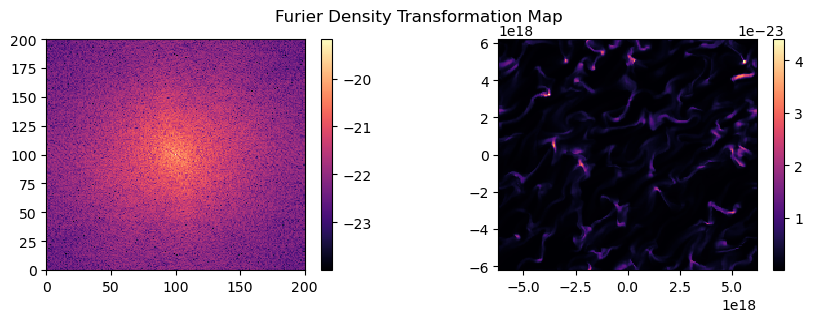

In [19]:
#Furier transform:
fourier = np.fft.fft2(rho)
shifted_fourier = np.fft.fftshift(fourier)

#Ploting
fourier_transform('Furier Density Transformation Map ',rho,shifted_fourier,"magma")

### Part D

In [14]:
#print(rho.shape)
#mask_1 = Image.new(mode="RGB", size=(200, 200))

In [93]:
def High_pass(radius_center,shifted_fourier):
    '''
    This functions creates ah high pass filte 
    -------------------------------------------------------------------------
    PARAMETERS: 
    -radius_center,shifted_fourier
    -------------------------------------------------------------------------
    OUTPUT:
    -Returns plot high pass image
    -------------------------------------------------------------------------
    '''
    #first calculate the image center: 
    image_centre = [shifted_fourier.shape[0]//2, shifted_fourier.shape[1]//2]
    
    #Defining the mask:
    mask_1 = Image.new(mode="RGB", size=(200, 200))
    draw = ImageDraw.Draw(mask_1)
    draw.ellipse((image_centre[0]-radius_centre, image_centre[1]-radius_centre, image_centre[0]+radius_centre,\
              image_centre[1]+radius_centre), fill=(200, 0, 0), outline=(0, 0, 0))
    mask_1 = np.array(mask_1)[:,:,0]//200
    
    #Defining the high_pass mask: 
    mask_2 = - mask_1 + 1
    masked_fourier = shifted_fourier*mask_2
    
    #Inverse_fourier transform:
    inv_filter = np.fft.ifftshift(masked_fourier)
    inv_filter = np.fft.ifft2(inv_filter)
    plt.figure(figsize = (8,6))
    Z = plt.pcolor(inv_filter.real, shading='auto', cmap ="viridis")

    plt.colorbar(Z)

    plt.show()

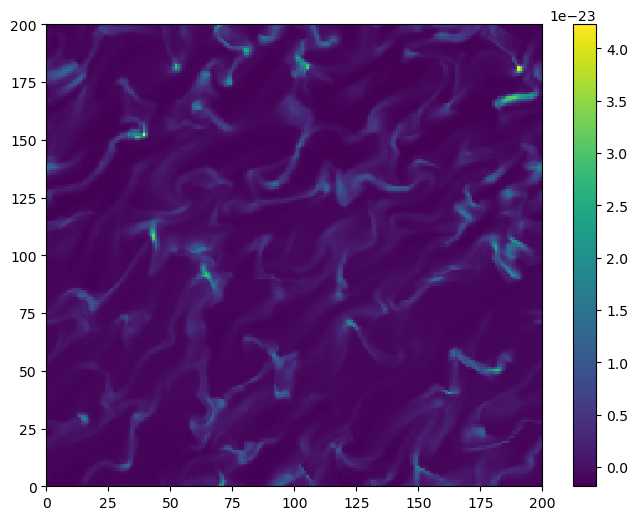

In [94]:
radius_center = 25#pixels
High_pass(radius_center,shifted_fourier)

## Part E

In [100]:
#We use the functin shown in class for the gaussian smoothing:
def mask_gaussian(x, y, sigma_x, sigma_y):
    """
    Function to get the 2D gaussian
    """
    
    return (1/(2*np.pi*sigma_x*sigma_y) *\
            np.exp(-(x**2/(2*sigma_x**2) \
                   + y**2/(2*sigma_y**2))))

In [119]:
def Gauss_analisis(sigma_x,sigma_y,array):
    '''
    This functions plots makes the gaussian mask for given sigmas
    -------------------------------------------------------------------------
    PARAMETERS: 
    -sigma_x,sigma_y,array
    -------------------------------------------------------------------------
    OUTPUT:
    -Returns gaussian mask
    -------------------------------------------------------------------------
    '''

    # We generate the vectors
    x = np.linspace(-10, 10, 200)  # Define x coordinates
    y = np.linspace(-10, 10, 200)  # Define y coordinates

    # We create the meshgrid
    X, Y = np.meshgrid(x, y)

    # For the surface
    surface = mask_gaussian(X, Y, sigma_x, sigma_y)
    
    #Make de fourirer analisis
    fourier = np.fft.fft2(array)
    
    #Shifted fourier:
    shifted_fourier = np.fft.fftshift(fourier)
    
    #making the mask
    mask = np.fft.fft2(surface)
    shifted_mask = np.fft.fftshift(mask)
    
    #Gaussian mask
    masked_new = shifted_fourier*shifted_mask
    
    #inverse fourier:
    inv_filter = np.fft.ifftshift(masked_new)
    inv_filter = np.fft.ifft2(inv_filter)
    
    #rotating the image: 
    inv_x = np.roll(inv_filter.real, inv_filter.shape[1]//2, axis = 1)
    inv_xy = np.roll(inv_x, inv_filter.shape[0]//2, axis = 0)
    return (inv_xy)

In [127]:
#calling the function for diferent sigmas: 
inv_xy = Gauss_analisis(0.8,0.8,rho)
inv_xy_2 = Gauss_analisis(0.4,0.4,rho)

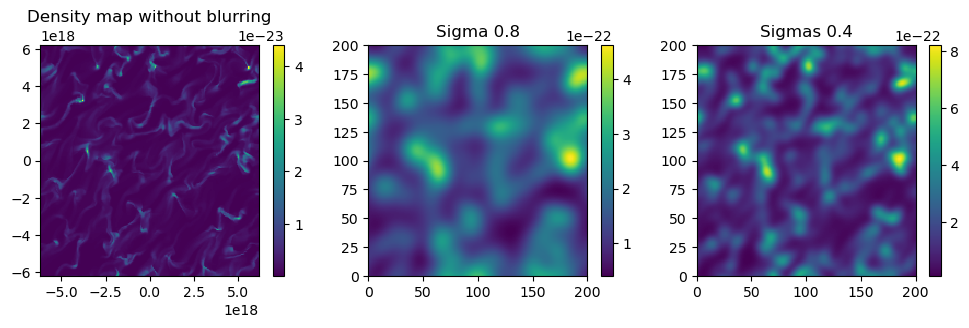

In [142]:
#Ploting:
fig, (ax1, ax2,ax3) = plt.subplots(1,3,figsize=(12,3))
im1 = ax1.pcolor(x_2d, y_2d,rho,cmap = "viridis")
ax1.title.set_text('Density map without blurring')
fig.colorbar(im1)
im2 = ax2.pcolor(inv_xy, shading='auto', cmap ="viridis")
ax2.title.set_text('Sigma 0.8')
fig.colorbar(im2)
im3 = ax3.pcolor(inv_xy_2, shading='auto', cmap ="viridis")
ax3.title.set_text('Sigmas 0.4')
fig.colorbar(im3)
    
#Adjusting the plots: 
plt.subplots_adjust(wspace=0.2,hspace=0.2)
plt.show()